In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
import torch 
import random 
import string
import copy 
import torch.nn.functional as F
import os 

import torch.distributions as dist
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

from cde.density_estimator import MixtureDensityNetwork

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--n', type=int, default=2000)
parser.add_argument('--d', type=int, default=1)
parser.add_argument('--nval', type=int, default=1000)
parser.add_argument('--alpha', type=float, default=0.1)
parser.add_argument('--niter', type=int, default=100)
parser.add_argument('--densitymodel', type=str, default='closeform')
parser.add_argument('--dgp', type=str, default='uniform2')
parser.add_argument('--lamb', type=float, default=1000)
parser.add_argument('--model', type=str, default='linear')
parser.add_argument('--conformalscore', type=str, default='residual')
parser.add_argument('--temperature', type=float, default=10.0)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--inflambda', type=int, default=0)

args = parser.parse_args([])
n = args.n
d = args.d
alpha = args.alpha
niter = args.niter
model = args.model
densitymodel = args.densitymodel

/home/ruijiang/.conda/envs/cdeenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ruijiang/.conda/envs/cdeenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ruijiang/.conda/envs/cdeenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ruijiang/.conda/envs/cdeenv/lib/python3.6/s

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists('./data'):
    os.makedirs('./data')
if not os.path.exists('./fig'):
    os.makedirs('./fig')
if not os.path.exists('./log'):
    os.makedirs('./log')

def conformalScore(Y, Yhat, sd = 1, samples = None):
    if args.conformalscore == 'residual':
        score = np.abs(Yhat - Y)
    elif args.conformalscore == 'normalized':
        score = np.abs(Yhat - Y) / sd
    elif args.conformalscore == 'quantile':
        score = np.max(np.vstack([Yhat[:,0] - Y, Y - Yhat[:,1]]), axis = 0)
    return score

def conformalScore_torch(Y, Yhat, sd = 1):
    if args.conformalscore == 'residual':
        score = torch.abs(Yhat - Y)
    elif args.conformalscore == 'normalized':
        score = torch.abs(Yhat - Y) / sd
    elif args.conformalscore == 'quantile':
        score = torch.max(torch.stack([Yhat[:,0] - Y, Y - Yhat[:,1]]), dim = 0)[0]        
    return score

def genY(X):
    if args.dgp == 'uniform2':
        y = copy.deepcopy(X[:,0])
        index = (X[:,0] < 2.2) & (X[:,0] > 2)
        y[index] = 0 + np.random.normal(size=(index).sum())
        y[~index] = 2 + np.random.normal(size=(~index).sum())
        return y
    if args.dgp == 'uniform3':
        y = np.random.normal(size=X.shape[0]) * 1
        return y

def genMean(X):
    if args.dgp == 'uniform2':
        y = copy.deepcopy(X[:,0])
        index = (X[:,0] < 2.2) & (X[:,0] > 2)
        y[index] = 0 
        y[~index] = 2
        return y
    elif args.dgp == 'uniform3':
        y = np.zeros(X.shape[0])
        return y

def genMean_torch(X):
    if args.dgp == 'uniform2':
        y = torch.zeros(X.shape[0]) + 2
        index = (X[:,0] < 2.2) & (X[:,0] > 2)
        y[index] = 0 
        return y
    if args.dgp == 'uniform3':
        y = torch.zeros(X.shape[0]) 
        return y    

def genX(n):
    return (np.random.uniform(size=n).reshape(-1,1) - 0.5) * 4 + 0.5

class closeFormdensityModel(torch.nn.Module):
    def __init__(self, d):
        super(closeFormdensityModel, self).__init__()

    def forward(self, x):
        ypred = x[:,-1]
        v = x[:,-2]
        x = x[:,0]
        p1 = v - genMean_torch(x.reshape(-1,1)) + ypred
        p2 = -v - genMean_torch(x.reshape(-1,1)) + ypred
        return torch.exp(-0.5 * p1 ** 2) / (np.sqrt(2*np.pi)) + torch.exp(-0.5 * p2 ** 2) / (np.sqrt(2*np.pi))

    def sample(self, x):
        return genMean_torch(x.reshape(-1,1)) + torch.randn(x.shape[0])


outfun = LinearRegression()

# torch linear model 
class LinearModel(torch.nn.Module):
    def __init__(self, d, out = 1):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(d, out)
        torch.nn.init.xavier_uniform_(self.linear.weight)
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    

# a MLP with LeakyReLU activation
class MLP(torch.nn.Module):
    def __init__(self, d):
        super(MLP, self).__init__()
        hidd = 2
        self.linear1 = torch.nn.Linear(d, hidd)
        self.linear2 = torch.nn.Linear(hidd, hidd)
        self.linear3 = torch.nn.Linear(hidd, 1)
        self.leakyrelu = torch.nn.LeakyReLU()
        self.relu = torch.nn.ReLU()
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)
        
    def forward(self, x):
        y_pred = self.linear1(x)
        y_pred = self.leakyrelu(y_pred)
        y_pred = self.linear2(y_pred)
        y_pred = self.leakyrelu(y_pred)
        y_pred = self.linear3(y_pred)
        return y_pred
    
    
# a class for the torch linear model with fit and predict methods
class TorchLinearModel():
    def __init__(self, d, out = 1):
        if args.model == 'linear':
            self.model = LinearModel(d, out)
        elif args.model == 'mlp':
            self.model = MLP(d)
        elif args.model == 'linear_cc':
            self.model = LinearModel(d, out)
        elif args.model == 'mlp_cc':
            self.model = MLP(d)
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        
    def fit(self, X, Y):
        X = torch.from_numpy(X).float()
        Y = torch.from_numpy(Y).float()
        quantiles = [0.05, 0.95]
        for t in range(1000):
            y_pred = self.model(X)

            if args.conformalscore == 'quantile':
                # pinball loss 
                loss = []
                for i,q in enumerate(quantiles):
                    e = Y - y_pred[:,i].reshape(-1)
                    loss.append(torch.max((q-1) * e, q * e).unsqueeze(1))
                loss = torch.mean(torch.cat(loss, dim = 1), dim = 1).mean()
            else:
                loss = ((y_pred.reshape(-1) - Y)**2).mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if t % 100 == 99:
                print(t, loss.item())
        return self

    def predict(self, X):
        X = torch.from_numpy(X).float()
        if args.conformalscore == 'quantile':
            return self.model(X).detach().numpy()
        else:
            return self.model(X).detach().numpy().reshape(-1)

class TorchLinearModel_CC():
    def __init__(self, d, out = 1, lamb = 1):
        self.model = LinearModel(d, out)
        self.lamb = lamb
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.lr)
        if densitymodel == 'closeform':
            self.density_model = closeFormdensityModel(d + 1)
            self.density_model.to(device)
        elif densitymodel == 'mdn':
            name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
        self.model.to(device)
        
    def fit(self, X, Y, X_CC, Y_CC):
        
        X_val = torch.from_numpy(X_CC).float().to(device)
        Y_val = torch.from_numpy(Y_CC).float().to(device)
        X_CC = torch.from_numpy(X).float().to(device)
        Y_CC = torch.from_numpy(Y).float().to(device)
        X = torch.from_numpy(X).float().to(device)
        Y = torch.from_numpy(Y).float().to(device)
        
        #first train a simple linear model
        quantiles = [0.05, 0.95]
        for t in range(500):
            y_pred = self.model(X)
            if args.conformalscore == 'quantile':
                # pinball loss 
                loss = []
                for i,q in enumerate(quantiles):
                    e = Y - y_pred[:,i].reshape(-1)
                    loss.append(torch.max((q-1) * e, q * e).unsqueeze(1))
                loss = torch.mean(torch.cat(loss, dim = 1), dim = 1).mean()
            else:
                loss = ((y_pred.reshape(-1) - Y)**2).mean()
            
            # Zero gradients, perform a backward pass, and update the weights.
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        for i in range(10):
            sampled = self.density_model.sample(X_CC.cpu().numpy())[1].reshape(-1)
            sampled = torch.from_numpy(sampled).float().to(device)
            y_pred = self.model(X_CC)
            if args.conformalscore == 'quantile':
                V_CC = conformalScore_torch(Y_CC, y_pred, sd = 1)
            else:
                V_sampled = conformalScore_torch(sampled, y_pred.reshape(-1))
            plt.plot(X_CC.cpu().numpy(), sampled.cpu().detach().numpy(), 'r.')
        print('Plotting sampled Y')
        plt.savefig('./sampled_Y.pdf')
        print('Saved.')
        plt.close()

        # get std 
        if args.conformalscore == 'residual':
            sd_val = 1
            sd_cc = 1
        else:
            nsamples = 500
            samples = np.zeros((X_val.shape[0], nsamples))
            for i in range(nsamples):
                samples[:,i] = self.density_model.sample(X_val.cpu().numpy())[1].reshape(-1)
            sd_val = np.std(samples, axis = 1)
            sd_val = torch.from_numpy(sd_val).float().to(device)

            samples_cc = np.zeros((X_CC.shape[0], nsamples))
            for i in range(nsamples):
                samples_cc[:,i] = self.density_model.sample(X_CC.cpu().numpy())[1].reshape(-1)
            sd_cc = np.std(samples_cc, axis = 1)
            sd_cc = torch.from_numpy(sd_cc).float().to(device)

        for t in range(100):
            y_pred = self.model(X_CC)
            if args.conformalscore == 'quantile':
                V_CC = conformalScore_torch(Y_CC, y_pred, sd = sd_cc)
            else:
                V_CC = conformalScore_torch(Y_CC, y_pred.reshape(-1), sd = sd_cc)
                        
            y_pred = self.model(X)
            if args.conformalscore == 'quantile':
                # pinball loss 
                loss = []
                for i,q in enumerate(quantiles):
                    e = Y - y_pred[:,i].reshape(-1)
                    loss.append(torch.max((q-1) * e, q * e).unsqueeze(1))
                loss = torch.mean(torch.cat(loss, dim = 1), dim = 1).mean()
            else:            
                loss = ((y_pred.reshape(-1) - Y)**2).mean()                   
            
            y_pred = self.model(X_CC)
            if args.conformalscore == 'quantile':
                V_CC = conformalScore_torch(Y_CC, y_pred, sd = sd_cc)
            else:
                V_CC = conformalScore_torch(Y_CC, y_pred.reshape(-1), sd = sd_cc)
            
            temperature = args.temperature
            wdiv = 0 
            wdiv = torch.zeros_like(V_CC)
            # random random nsamples samples from V_CC
            nsamples = 100
            for i in torch.randperm(X_CC.shape[0])[:nsamples]:
                V_CC_sample = V_CC[torch.randperm(V_CC.shape[0])[:nsamples]]
                if args.conformalscore == 'quantile':
                    V_givenx = conformalScore_torch(torch.from_numpy(self.density_model.sample(torch.ones_like(X_CC).cpu().numpy() * X_CC[i,].cpu().numpy())[1].reshape(-1)).to(device), \
                                                    torch.ones_like(y_pred) * y_pred[i,], sd = sd_cc)
                else:
                    V_givenx = conformalScore_torch(torch.from_numpy(self.density_model.sample(torch.ones_like(X_CC).cpu().numpy() * X_CC[i,].cpu().numpy())[1].reshape(-1)).to(device), \
                                                    torch.ones_like(y_pred.reshape(-1)) * y_pred[i,], sd = sd_cc)
                # max over v 
                diff = approx_ecdf(V_givenx, V_CC_sample, grid_size = 200, temperature = temperature)
                wdiv[i] = diff.max()
            # max over x
            div = wdiv.max()

            loss1 = loss + self.lamb * div
            print('t = ', t, 'loss = ', loss, 'div = ', div, 'loss1 = ', loss1)

            # Zero gradients, perform a backward pass, and update the weights.
            self.optimizer.zero_grad()
            loss1.backward()
            self.optimizer.step()
        
            alpha = 0.1
            
            if args.conformalscore == 'quantile':
                y_pred = self.model(X_val)
                Yhat_test = self.model(torch.from_numpy(Xtest).float().to(device))
            else:
                y_pred = self.model(X_val).reshape(-1)
                Yhat_test = self.model(torch.from_numpy(Xtest).float().to(device)).reshape(-1)
            V_CC = conformalScore_torch(Y_val, y_pred, sd = sd_val)
            if args.conformalscore == 'residual':
                Yscore = conformalScore(Y_val.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), sd = 1)
            elif args.conformalscore == 'quantile':
                Yscore = conformalScore(Y_val.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), sd = sd_val.cpu().detach().numpy())
            else:
                Yscore = conformalScore(Y_val.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), sd = sd_val.cpu().detach().numpy())

            qhat = np.quantile(Yscore, np.ceil((nval+1)*(1-alpha))/nval, interpolation='higher')
            Yslack = qhat

            print(f'cutoff is {Yslack}')
            if args.conformalscore == 'residual':
                Ylo = Yhat_test.cpu().detach().numpy() - Yslack
                Yup = Yhat_test.cpu().detach().numpy() + Yslack
            elif args.conformalscore == 'quantile':
                Ylo = Yhat_test.cpu().detach().numpy()[:,0] - Yslack 
                Yup = Yhat_test.cpu().detach().numpy()[:,1] + Yslack 
            else:
                Ylo = Yhat_test.cpu().detach().numpy() - Yslack * test_std
                Yup = Yhat_test.cpu().detach().numpy() + Yslack * test_std

            CI = pd.DataFrame({"lower": Ylo.reshape(-1), "upper": Yup.reshape(-1)})

            # check if the coverage is correct
            if t % 10 == 0:
                cc = norm.cdf(Yup - genMean(Xtest), loc = 0, scale = 1) - norm.cdf(Ylo - genMean(Xtest), loc = 0, scale = 1)
                conditional_coverage.append(np.min(cc))
                print(f'the minimum point is {Xtest[np.argmin(cc)]}')
                print(f'Coverage is {np.mean((Ylo <= Ytest) & (Ytest <= Yup))}')
                print(f'Average coverage set size is {np.mean(Yup - Ylo)}')
                print(f'Average conditional coverage is {np.min(cc)}')
        return self
    
    def predict(self, X):
        X = torch.from_numpy(X).float().to(device)
        if args.conformalscore == 'quantile':
            return self.model(X).cpu().detach().numpy()
        else:
            return self.model(X).cpu().detach().numpy().reshape(-1)


def approx_ecdf(points1, points2, grid_size = 100, temperature = 5):
    tgrid = torch.linspace(min(min(points1), min(points2)).item(), max(max(points1),max(points2)).item(), grid_size).to(device)
    
    cdf1 = (torch.sigmoid(temperature * (tgrid - points1.reshape(-1,1)))).mean(0)
    cdf2 = (torch.sigmoid(temperature * (tgrid - points2.reshape(-1,1)))).mean(0)
    diff = torch.abs(cdf1 - cdf2)
    return diff 

if args.conformalscore == 'quantile':
    linearmodel = TorchLinearModel(1,out = 2)
else:
    linearmodel = TorchLinearModel(1)
#linearmodel = LinearRegression()


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

coverage = []
conditional_coverage = []
set_size = []
alpha_grid = np.linspace(0.1, 0.9, 10)
results = pd.DataFrame({"iter": [], "alpha": [], "coverage": [], "set_size": [], "conditional_coverage": [], 'mse': []})

mdn_results = pd.DataFrame({"iter": [], "alpha": [], "coverage": [], "set_size": [], "conditional_coverage": [], 'mse': []})

99 1.4164950847625732
199 1.3746347427368164
299 1.3380004167556763
399 1.3061546087265015
499 1.2786716222763062
599 1.2551378011703491
699 1.2351534366607666
799 1.218334436416626
899 1.2043147087097168
999 1.192747712135315
cutoff is 1.8059830067361924
the minimum point is [2.00002325]
Coverage is 0.8995
Average coverage set size is 3.6119656562805176
Average conditional coverage is 0.5793524534370178


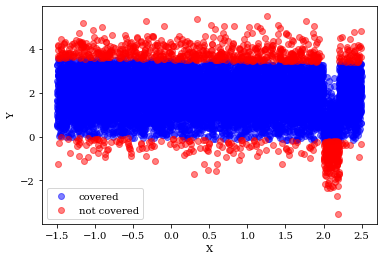

In [6]:
# first show linear model 
seed_everything(3)

n = 2000
d = 10
X = genX(n)
# density of X
Y = genY(X)

alpha = 0.1

test_mean = 0
test_std = 1
ntest = 10000

Xtest = genX(ntest)
Ytest = genY(Xtest)

Xtrain = X
nval = 500
Xval = genX(nval)
Yval = genY(Xval)
nsamples = 100 

# fit a density model 
if (args.model == 'linear' or args.model == 'mlp') and args.conformalscore == 'residual':
    1
else:
    name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=11))
    density_model = MixtureDensityNetwork(name, X.shape[1], 1, n_centers=100, hidden_sizes=(32, 32), n_training_epochs=2000, dropout = 0.1)
    density_model.fit(X, Y.reshape(-1,1))

if model == 'linear':
    Ymodel = linearmodel.fit(X, Y)
elif model == 'linear_cc':
    Ymodel = linearmodel.fit(X, Y)
elif model == 'mlp':
    Ymodel = linearmodel.fit(X, Y)
elif model == 'mlp_cc':
    Ymodel = linearmodel.fit(X, Y)

if (args.model == 'linear' or args.model == 'mlp') and args.conformalscore == 'residual':
    test_std = 1
else:
    nsamples = 500
    samples = np.zeros((ntest, nsamples))
    for i in range(nsamples):
        samples[:,i] = density_model.sample(Xtest)[1].reshape(-1)
    test_std = np.std(samples, axis = 1)

    for alpha in alpha_grid:
        # evaluate density model's conditional/marginal coverage
        Y_lo = np.quantile(samples, alpha/2, axis = 1)
        Y_up = np.quantile(samples, 1 - alpha/2, axis = 1)
        marginal_coverage = np.mean((Y_lo <= Ytest) & (Ytest <= Y_up))
        print(f'marginal coverage of density model is {marginal_coverage}')
        cc = norm.cdf(Y_up - genMean(Xtest), loc = 0, scale = 1) - norm.cdf(Y_lo - genMean(Xtest), loc = 0, scale = 1)
        print(f'iter {iter} conditional coverage of density model is {np.min(cc)}')
        est_mean = np.mean(samples, axis = 1)

        mdn_results = pd.concat([mdn_results, pd.DataFrame({"iter": [iter], "alpha": [alpha], "coverage": [np.mean((Y_lo <= Ytest) & (Ytest <= Y_up))], "set_size": [np.mean(Y_up - Y_lo)], "conditional_coverage": [np.min(cc)], 'mse': [((Ytest - est_mean)**2).mean()]})])

    alpha = 0.1
    Y_lo = np.quantile(samples, alpha/2, axis = 1)
    Y_up = np.quantile(samples, 1 - alpha/2, axis = 1)
    covered_index = ((Y_lo <= Ytest) & (Ytest <= Y_up))
    plt.scatter(Xtest[covered_index].reshape(-1), Ytest[covered_index], c = 'blue', alpha=0.5, label = 'covered')
    plt.scatter(Xtest[~covered_index].reshape(-1), Ytest[~covered_index], c= 'red', alpha=0.5, label = 'not covered')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(f'./fig/syn/{args.dgp}_{alpha}_genmodel_{args.densitymodel}_{iter}.png')
    plt.close()
    mdn_results.to_csv(f'./log/{args.dgp}_genmodel_{args.densitymodel}_coverage.csv', index=False)
    mdn_results_mean = mdn_results.groupby('alpha').mean().reset_index()
    mdn_results_se = mdn_results.groupby(['alpha']).std().reset_index() / np.sqrt(5)
    mdn_results_se.columns = [each + '_se' for each in mdn_results_se.columns]
    mdn_results_sum = pd.concat([mdn_results_mean, mdn_results_se], axis = 1)
    mdn_results_sum.to_csv(f'./log/{args.dgp}_genmodel_{args.densitymodel}_coverage_summary.csv', index=False)        

if (args.model == 'linear' or args.model == 'mlp') or args.conformalscore == 'residual' or args.conformalscore == 'quantile':
    val_std = 1
    samples_val = np.zeros((nval, 100))
else:
    samples_val = np.zeros((nval, 100))
    for i in range(nsamples):
        samples_val[:,i] = density_model.sample(Xval)[1].reshape(-1)
    val_std = np.std(samples_val, axis = 1)

Yhat1 = Ymodel.predict(Xval)
if args.conformalscore == 'slcp_residual':
    Yscore = conformalScore(Yval, Yhat1, sd = val_std, samples = samples_val)
elif args.conformalscore == 'quantile':
    Yscore = conformalScore(Yval, Yhat1, sd = val_std)
else:
    Yscore1 = conformalScore(Yval, Yhat1, sd = val_std, samples = samples_val)
    Yscore = Yscore1


if model == 'linear_cc':
    if args.conformalscore == 'quantile':
        linearmodel_cc = TorchLinearModel_CC(1, out = 2, lamb=args.lamb)
    else:
        linearmodel_cc = TorchLinearModel_CC(1, lamb=args.lamb)
    linearmodel_cc.density_model = density_model
    Ymodel = linearmodel_cc.fit(X, Y, Xval, Yval)

    Yhat = Ymodel.predict(Xval)
    Yscore = conformalScore(Yval, Yhat, sd = val_std)

Yhat_test = Ymodel.predict(Xtest)        

if args.conformalscore == 'slcp_residual':
    alpha_grid = [alpha]
if args.conformalscore == 'quantile':
    alpha_grid = [0.1]

alpha = 0.1 
qhat = np.quantile(Yscore, np.ceil((nval+1)*(1-alpha))/nval, interpolation='higher')
Yslack = qhat

print(f'cutoff is {Yslack}')
if args.conformalscore == 'residual':
    Ylo = Yhat_test - Yslack
    Yup = Yhat_test + Yslack
elif args.conformalscore == 'normalized':
    Ylo = Yhat_test - Yslack * test_std
    Yup = Yhat_test + Yslack * test_std
elif args.conformalscore == 'slcp_residual':
    Ylo = Yhat_test - np.quantile(np.abs(Yhat_test.reshape(-1,1)-samples), 1-alpha, interpolation='higher',axis = 1) - Yslack
    Yup = Yhat_test + np.quantile(np.abs(samples-Yhat_test.reshape(-1,1)), 1-alpha, interpolation='higher', axis = 1) + Yslack
elif args.conformalscore == 'quantile':
    Ylo = Yhat_test[:,0] - Yslack
    Yup = Yhat_test[:,1] + Yslack

CI = pd.DataFrame({"lower": Ylo.reshape(-1), "upper": Yup.reshape(-1)})

# check if the coverage is correct
if args.dgp == 'uniformadaptive':
    index = (Xtest[:,0] < 1.8) & (Xtest[:,0] > 1.6)
    cc = norm.cdf(Yup - genMean(Xtest), loc = 0, scale = 1) - norm.cdf(Ylo - genMean(Xtest), loc = 0, scale = 1)
    cc[index] = norm.cdf(Yup[index] - genMean(Xtest[index]), loc = 0, scale = 2) - norm.cdf(Ylo[index] - genMean(Xtest[index]), loc = 0, scale = 2)
else:
    cc = norm.cdf(Yup - genMean(Xtest), loc = 0, scale = 1) - norm.cdf(Ylo - genMean(Xtest), loc = 0, scale = 1)
conditional_coverage.append(np.min(cc))
print(f'the minimum point is {Xtest[np.argmin(cc)]}')
print(f'Coverage is {np.mean((Ylo <= Ytest) & (Ytest <= Yup))}')
print(f'Average coverage set size is {np.mean(Yup - Ylo)}')
print(f'Average conditional coverage is {np.min(cc)}')
coverage.append(np.mean((Ylo <= Ytest) & (Ytest <= Yup)))
set_size.append(np.mean(Yup - Ylo))
# estimate the conditional coverage
# cdf of Yup and Ylo

# plot the points that is covered 
covered_index = ((Ylo <= Ytest) & (Ytest <= Yup))
plt.scatter(Xtest[covered_index].reshape(-1), Ytest[covered_index], c = 'blue', alpha=0.5, label = 'covered')
plt.scatter(Xtest[~covered_index].reshape(-1), Ytest[~covered_index], c= 'red', alpha=0.5, label = 'not covered')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig(f'./fig/syn/{args.dgp}_{alpha}_{args.model}_{args.lamb}_{args.densitymodel}_{args.conformalscore}_{args.temperature}_{iter}.png')
plt.show()
plt.close()

2000/2000 [100%] ██████████████████████████████ Elapsed: 208s | loss: 2541.097
mean log-loss train: 1.2705
99 1.2206411361694336
199 1.20576810836792
299 1.1935746669769287
399 1.183693289756775
499 1.175782561302185
599 1.1695324182510376
699 1.1646628379821777
799 1.160925030708313
899 1.158101201057434
999 1.1560032367706299
marginal coverage of density model is 0.8822
iter <built-in function iter> conditional coverage of density model is 0.7653379477004637
marginal coverage of density model is 0.7842
iter <built-in function iter> conditional coverage of density model is 0.6489226107439225
marginal coverage of density model is 0.6972
iter <built-in function iter> conditional coverage of density model is 0.5471427145349037
marginal coverage of density model is 0.6075
iter <built-in function iter> conditional coverage of density model is 0.4680168995245968
marginal coverage of density model is 0.52
iter <built-in function iter> conditional coverage of density model is 0.36452637493514

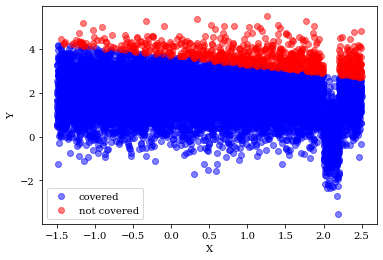

In [6]:
# regularize the model
seed_everything(3)

n = 2000
d = 10
X = genX(n)
# density of X
Y = genY(X)

alpha = 0.1

test_mean = 0
test_std = 1
ntest = 10000

Xtest = genX(ntest)
Ytest = genY(Xtest)

Xtrain = X
nval = 500
Xval = genX(nval)
Yval = genY(Xval)
nsamples = 100 

args.model = 'linear_cc'
model = args.model
args.lamb = 1000


# fit a density model 
if (args.model == 'linear' or args.model == 'mlp') and args.conformalscore == 'residual':
    1
else:
    name = 'linearcctest'
    #density_model = MixtureDensityNetwork(name, X.shape[1], 1, n_centers=100, hidden_sizes=(32, 32), n_training_epochs=2000, dropout = 0.1)
    density_model = MixtureDensityNetwork(name, X.shape[1], 1, n_centers=100, hidden_sizes=(32, 32), n_training_epochs=2000)
    density_model.fit(X, Y.reshape(-1,1))

if model == 'linear':
    Ymodel = linearmodel.fit(X, Y)
elif model == 'linear_cc':
    Ymodel = linearmodel.fit(X, Y)
elif model == 'mlp':
    Ymodel = linearmodel.fit(X, Y)
elif model == 'mlp_cc':
    Ymodel = linearmodel.fit(X, Y)

if (args.model == 'linear' or args.model == 'mlp') and args.conformalscore == 'residual':
    test_std = 1
else:
    nsamples = 500
    samples = np.zeros((ntest, nsamples))
    for i in range(nsamples):
        samples[:,i] = density_model.sample(Xtest)[1].reshape(-1)
    test_std = np.std(samples, axis = 1)

    for alpha in alpha_grid:
        # evaluate density model's conditional/marginal coverage
        Y_lo = np.quantile(samples, alpha/2, axis = 1)
        Y_up = np.quantile(samples, 1 - alpha/2, axis = 1)
        marginal_coverage = np.mean((Y_lo <= Ytest) & (Ytest <= Y_up))
        print(f'marginal coverage of density model is {marginal_coverage}')
        cc = norm.cdf(Y_up - genMean(Xtest), loc = 0, scale = 1) - norm.cdf(Y_lo - genMean(Xtest), loc = 0, scale = 1)
        print(f'iter {iter} conditional coverage of density model is {np.min(cc)}')
        est_mean = np.mean(samples, axis = 1)

        mdn_results = pd.concat([mdn_results, pd.DataFrame({"iter": [iter], "alpha": [alpha], "coverage": [np.mean((Y_lo <= Ytest) & (Ytest <= Y_up))], "set_size": [np.mean(Y_up - Y_lo)], "conditional_coverage": [np.min(cc)], 'mse': [((Ytest - est_mean)**2).mean()]})])

    alpha = 0.1
    Y_lo = np.quantile(samples, alpha/2, axis = 1)
    Y_up = np.quantile(samples, 1 - alpha/2, axis = 1)
    covered_index = ((Y_lo <= Ytest) & (Ytest <= Y_up))
    plt.scatter(Xtest[covered_index].reshape(-1), Ytest[covered_index], c = 'blue', alpha=0.5, label = 'covered')
    plt.scatter(Xtest[~covered_index].reshape(-1), Ytest[~covered_index], c= 'red', alpha=0.5, label = 'not covered')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(f'./fig/syn/{args.dgp}_{alpha}_genmodel_{args.densitymodel}_{iter}.png')
    plt.close()
    mdn_results.to_csv(f'./log/{args.dgp}_genmodel_{args.densitymodel}_coverage.csv', index=False)
    mdn_results_mean = mdn_results.groupby('alpha').mean().reset_index()
    mdn_results_se = mdn_results.groupby(['alpha']).std().reset_index() / np.sqrt(5)
    mdn_results_se.columns = [each + '_se' for each in mdn_results_se.columns]
    mdn_results_sum = pd.concat([mdn_results_mean, mdn_results_se], axis = 1)
    mdn_results_sum.to_csv(f'./log/{args.dgp}_genmodel_{args.densitymodel}_coverage_summary.csv', index=False)        

if (args.model == 'linear' or args.model == 'mlp') or args.conformalscore == 'residual' or args.conformalscore == 'quantile':
    val_std = 1
    samples_val = np.zeros((nval, 100))
else:
    samples_val = np.zeros((nval, 100))
    for i in range(nsamples):
        samples_val[:,i] = density_model.sample(Xval)[1].reshape(-1)
    val_std = np.std(samples_val, axis = 1)

Yhat1 = Ymodel.predict(Xval)
if args.conformalscore == 'quantile':
    Yscore = conformalScore(Yval, Yhat1, sd = val_std)
else:
    Yscore1 = conformalScore(Yval, Yhat1, sd = val_std, samples = samples_val)
    Yscore = Yscore1

if model == 'linear_cc':
    if args.conformalscore == 'quantile':
        linearmodel_cc = TorchLinearModel_CC(1, out = 2, lamb=args.lamb)
    else:
        linearmodel_cc = TorchLinearModel_CC(1, lamb=args.lamb)
    linearmodel_cc.density_model = density_model
    Ymodel = linearmodel_cc.fit(X, Y, Xval, Yval)

    Yhat = Ymodel.predict(Xval)
    Yscore = conformalScore(Yval, Yhat, sd = val_std)

Yhat_test = Ymodel.predict(Xtest)        

if args.conformalscore == 'slcp_residual':
    alpha_grid = [alpha]
if args.conformalscore == 'quantile':
    alpha_grid = [0.1]

alpha = 0.1 
qhat = np.quantile(Yscore, np.ceil((nval+1)*(1-alpha))/nval, interpolation='higher')
Yslack = qhat

print(f'cutoff is {Yslack}')
if args.conformalscore == 'residual':
    Ylo = Yhat_test - Yslack
    Yup = Yhat_test + Yslack
elif args.conformalscore == 'normalized':
    Ylo = Yhat_test - Yslack * test_std
    Yup = Yhat_test + Yslack * test_std
elif args.conformalscore == 'slcp_residual':
    Ylo = Yhat_test - np.quantile(np.abs(Yhat_test.reshape(-1,1)-samples), 1-alpha, interpolation='higher',axis = 1) - Yslack
    Yup = Yhat_test + np.quantile(np.abs(samples-Yhat_test.reshape(-1,1)), 1-alpha, interpolation='higher', axis = 1) + Yslack
elif args.conformalscore == 'quantile':
    Ylo = Yhat_test[:,0] - Yslack
    Yup = Yhat_test[:,1] + Yslack

CI = pd.DataFrame({"lower": Ylo.reshape(-1), "upper": Yup.reshape(-1)})

# check if the coverage is correct
cc = norm.cdf(Yup - genMean(Xtest), loc = 0, scale = 1) - norm.cdf(Ylo - genMean(Xtest), loc = 0, scale = 1)
conditional_coverage.append(np.min(cc))
print(f'the minimum point is {Xtest[np.argmin(cc)]}')
print(f'Coverage is {np.mean((Ylo <= Ytest) & (Ytest <= Yup))}')
print(f'Average coverage set size is {np.mean(Yup - Ylo)}')
print(f'Average conditional coverage is {np.min(cc)}')
coverage.append(np.mean((Ylo <= Ytest) & (Ytest <= Yup)))
set_size.append(np.mean(Yup - Ylo))
# estimate the conditional coverage
# cdf of Yup and Ylo

# plot the points that is covered 
covered_index = ((Ylo <= Ytest) & (Ytest <= Yup))
plt.scatter(Xtest[covered_index].reshape(-1), Ytest[covered_index], c = 'blue', alpha=0.5, label = 'covered')
plt.scatter(Xtest[~covered_index].reshape(-1), Ytest[~covered_index], c= 'red', alpha=0.5, label = 'not covered')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig(f'./fig/syn/{args.dgp}_{alpha}_{args.model}_{args.lamb}_{args.densitymodel}_{args.conformalscore}_{args.temperature}_{iter}.png')
plt.show()
plt.close()